In [1]:
import sys
sys.path.append('/Users/zhengj10/Python/Modules')
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd
import PatcherBot as pb
from glob import glob
import seaborn as sns
from scipy.stats import mannwhitneyu
import scipy.signal as ss

### Check individual data

In [2]:
# plt.figure(figsize=[12,3])

# imgFile = '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.04.20_000/plate_006/patch_attempt_0000_000/camera_clamp1_000/000/Camera/frames.ma'
# imgData = h5py.File(imgFile,'r')
# imgData = imgData['data'][()]

# F = []
# for frame in range(imgData.shape[0]):
#     f = np.mean(imgData[frame,234:274,:])
#     F.append(f)
# # plt.plot(F[480:600])
# plt.plot(F)

# daqFile = '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.04.20_000/plate_006/patch_attempt_0000_000/camera_clamp1_000/000/Camera/daqResult.ma'
# daqData = h5py.File(daqFile,'r')
# daqData = daqData['data'][()]
# # daqData.shape
# # plt.plot(daqData[0])
# vSync = daqData[0]
# b = np.diff(vSync)
# # plt.plot(b[900:1000])
# plt.plot(b)
# # plt.plot(vSync[900:1000])
# peaks, _ = ss.find_peaks(b, height=3*1e9)
# plt.scatter(peaks,b[peaks],color='pink')
# plt.xlim([0,1000])

# plt.tight_layout()
# plt.show()

### Data path specification

In [2]:
rawPath = '/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw'
imgPath = '/Volumes/genie/BenArthur/patch-screen/bot'
sumPath = '/Volumes/genie/Jihong_GENIE_stuff/Ace based sensors'
savePath = '/Volumes/genie/Presentations/Jihong/GENIE production/220419'

if not os.path.exists(savePath):
    os.makedirs(savePath)
os.path.exists(sumPath)

True

### Creation of dataframe for new session

#### Meta data

In [ ]:
datePath = ['2022.04.20_000']

In [ ]:
columns = ['Date','Plate','Well','Mutation','Cell']

In [ ]:
# # 2022.04.06_000 data, all plates
# bad_cells = {
#     'plate_004':['patch_attempt_0048_000'],
#     'plate_006':['patch_attempt_0014_000']    
# }

# # 2022.04.13_000 data, all plates
# bad_cells = {
#     'plate_001':['patch_attempt_0015_000'],
#     'plate_003':['patch_attempt_0034_000'],
#     'plate_006':['patch_attempt_0027_000','patch_attempt_0044_000']  
# }

# # 2022.04.20_000 data, all plates
# bad_cells = {
#     'plate_001':['patch_attempt_0012_000'],
#     'plate_003':['patch_attempt_0043_000','patch_attempt_0004_000'],
#     'plate_006':['patch_attempt_0026_000']
# }

In [ ]:
data_all = {}
for column in columns:
    data_all[column] = []

for date in datePath:
    platePath = pb.getPathInfo(os.path.join(imgPath,date))
#     platePath = ['/Volumes/genie/Jihong_GENIE_stuff/PatcherBot/raw/2022.03.10_000/plate_001']
    i=0
    for plate in platePath:
        print(plate)
        
        idxFile = os.path.join(imgPath, date, plate, '.index')
        a = yaml.load(open(idxFile), Loader=yaml.FullLoader)
        i+=1
        try:
            mutation = a['.']['mutation_1']
        except:
            mutation = 'not recorded'
        
        cellPath = pb.getPathInfo(os.path.join(imgPath, date, plate))
        print(mutation)
        for cell in(cellPath):
            trialPath = os.path.join(imgPath,date,plate,cell,'camera_clamp1_000')
            if not os.path.exists(trialPath):
                continue
            if plate in bad_cells.keys() and cell in bad_cells[plate]:
                continue
                
            data_all['Date'].append(date)
            data_all['Plate'].append(plate)
            data_all['Well'].append('well_1')
            data_all['Mutation'].append(mutation)
            data_all['Cell'].append(cell)

In [ ]:
for k,v in data_all.items():
    print(k,len(v))

In [ ]:
df_new = pd.DataFrame(data_all)
df_new

#### Calculate dFF and add to dataframe

In [ ]:
def get_dff(trace,fb):
    trace = np.array(trace)
    
    f0 = np.mean(trace[300:400])
    df_transient = np.mean(trace[495:505])-f0
    df_steady = np.mean(trace[950:1050])-f0
    
    dff_trace = (trace-f0)/(f0-fb)
    dff_transient = df_transient/(f0-fb)
    dff_steady = df_steady/(f0-fb)

    return dff_trace,dff_transient,dff_steady

In [ ]:
def get_leak(maFile): # maFile is Clamp2.ma file (for manipulator_2)
    data = h5py.File(maFile,'r')
    IV_traces = data['data'][()]
    leak = np.mean(IV_traces[0][9000:11000])
    leak = leak * 1e12 # convert to pA
    return leak

In [ ]:
def get_Ra(maFile,i): # maFile is Clamp2.ma file (for manipulator_2)
    data = h5py.File(maFile,'r')    
    IV_traces = data['data'][()]
    leak = get_leak(maFile)
    if i < 6:
        I_peak = np.max(IV_traces[0][19000:21000])
        I_peak = I_peak * 1e12 # convert to pA
        I_peak = I_peak - leak
    else:
        I_peak = np.min(IV_traces[0][19000:21000])
        I_peak = I_peak * 1e12
        I_peak = I_peak - leak
    V = np.mean(IV_traces[2][39000:41000]) - np.mean(IV_traces[2][9000:11000])
    Ra = V*1e6/I_peak # Convert to megaOhm
    return Ra

#### Create mask and get dFF etc

In [ ]:
plt.figure(figsize=[12,20.5])

dFF_all = []
peak_dFF_all = []
Leak = []
Ra = []
Leak_min = []
Ra_max = []
light_source = []
power = []
dFF_traces = []
Raw_traces = []
Filter = []

for i,r in df_new.iterrows():
    print(r['Date'],r['Plate'],r['Cell'])
    
    imgData = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'camera_clamp1_000/000/Camera/frames.ma')  
    imgData = h5py.File(imgData,'r')
    imgData = imgData['data'][()]
    
    p_val = []
    for row in range(imgData.shape[1]):
        for c in range(imgData.shape[2]):
            a = imgData[100:400,row,c]
            b = imgData[750:1050,row,c]
            stat, p = mannwhitneyu(a, b, alternative='two-sided')
            p_val.append(p)
            
    p_val_2d = np.reshape(p_val,[imgData.shape[1],imgData.shape[2]])
    thre = sorted(p_val)[500] # Pick up 500 lowest p_val
    
    mask = p_val_2d<thre
    ax = plt.subplot(3,20,i+1)
    ax.imshow(mask,cmap='gray')
    ax.text(15,50,r['Mutation'],color='y',size=18,weight='bold',ha='center',rotation=-90)
    ax.axis('off')
    
    savePath = os.path.join(sumPath,r['Date'],r['Plate'],r['Cell'])
    if not os.path.exists(savePath):
        os.makedirs(savePath)
    np.save(savePath+'/mask',mask)
  
    dff_single_cell = []
    peak_dff_single_cell = [] # For Voltron peak-dFF
    leaks = []
    ra_s = []
    raw_trace_single_cell = []
    dff_trace_single_cell = []
    for trial in range(9):
        imgData = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'camera_clamp1_000',str(trial).zfill(3),'Camera/frames.ma')
        ivFile = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'camera_clamp1_000',str(trial).zfill(3),'Clamp1.ma')
        
        imgData = h5py.File(imgData,'r')
        imgData = imgData['data'][()]
        leak = get_leak(ivFile)
        if trial !=6: # voltage amplitude = 0
            ra = get_Ra(ivFile,trial)
        
        leaks.append(leak)
        ra_s.append(ra)

        f_single_trial = []
        for frame in range(imgData.shape[0]):
            act_pix = imgData[frame,:,:]*mask
            f_single_frame = np.sum(act_pix)/np.sum(mask)
            f_single_trial.append(f_single_frame)

        imgMean = np.mean(imgData,axis=0)
        imgMean = imgMean.flatten()
        fb = sorted(imgMean)[int(imgMean.shape[0]*0.06)]
        
        raw_trace_single_cell.append(f_single_trial[:1900])
        dff_trace,dff_transient_single_trial,dff_steady_single_trial = get_dff(f_single_trial,fb)
        
        dff_trace_single_cell.append(dff_trace[:1900])
        peak_dff_single_cell.append(dff_transient_single_trial)        
        dff_single_cell.append(dff_steady_single_trial)

    Leak.append(leaks)
    Ra.append(ra_s)
    Leak_min.append(np.min(leaks))
    Ra_max.append(np.max(ra_s))
    
    Raw_traces.append(raw_trace_single_cell)
    dFF_traces.append(dff_trace_single_cell)
    
    dFF_all.append(dff_single_cell)
    peak_dFF_all.append(peak_dff_single_cell)
    light_source.append('Teal')
    power.append(40)
    Filter.append('Voltron filter')
#     if i>0:
#         break

plt.tight_layout(pad=0.3)
# plt.savefig(savePath + '/mask_V_series.png')
plt.show()

In [ ]:
df_new['dFF_transient'] = peak_dFF_all
df_new['dFF_steady'] = dFF_all
  
df_new['Raw_traces'] = Raw_traces
df_new['dFF_traces']= dFF_traces
       
df_new['Leak'] = Leak
df_new['Ra'] = Ra
df_new['Leak_min'] = Leak_min
df_new['Ra_max'] = Ra_max
# df_new['Light_source'] = light_source
df_new['Light_source'] = 'Cyan'
df_new['Power (%)'] = power
df_new['Filter'] = Filter
df_new['Remarks'] = 'None'

In [ ]:
# df_new

#### Append to existing data

In [ ]:
df = pd.read_pickle(sumPath+'/Ace_sensors_summary_pos_to_neg_VC_500_lowest_p_val.pkl')
print(df.shape)
df.columns

In [ ]:
df.Date.unique()

In [3]:
# df = df.drop(list(np.arange(390,415)))
# df['Remarks'] = 'Camera exposure signal incorrect'
# df

In [4]:
df = pd.concat([df,df_new],axis=0) # df.append deprecated
df.shape

NameError: name 'df' is not defined

In [5]:
df.to_pickle(sumPath+'/Ace_sensors_summary_pos_to_neg_VC_500_lowest_p_val.pkl')

NameError: name 'df' is not defined

### Plot

#### Load existing dataset and generate dataframe for plot (df_p)

In [3]:
df = pd.read_pickle(sumPath+'/Ace_sensors_summary_pos_to_neg_VC_500_lowest_p_val.pkl')
# df = df_new
df.shape
# df.Date.unique()

(159, 19)

In [4]:
# df = df.drop(278)
# df[df.Mutation=='421.1076']
# df[df['Mutation']=='R334']

- Filter data by data quality (leak and SR)

In [5]:
threshold = {'leak':-200, 'Rs':30}

In [6]:
df_p = df[(df.Leak_min>threshold['leak'])&(df.Ra_max<threshold['Rs'])&(df.Filter!='Filter set with excitation filter')]
df_p.shape

(136, 19)

In [7]:
# df.Filter.unique()
# df.columns

In [8]:
# df_p['Off_time'].median()

- Get construct info (from map file Jeremy sent)

In [9]:
mapFile = '/Volumes/genie/Jihong_GENIE_stuff/Ace based sensors/Mapping/Ace_blind_patch_list.xlsx'
df_map = pd.read_excel(mapFile)

/Users/zhengj10/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [10]:
Patch_ID = []
ID = []
Construct = []
for i,r in df_map.iterrows():
    jihong_id = r['Jihong ID:'].split('-')[1]+r['Jihong ID:'].split('-')[2]
    construct = r['Final Name']
    Patch_ID.append(jihong_id)
    ID.append(r['ID:'].replace('dot','.'))
    if 'pcDNA' in construct:
        Construct.append(construct.split('.')[0]+'.'+construct.split('.')[1])
    else:
        Construct.append(construct.split('.')[0])

In [11]:
df_construct_map = pd.DataFrame({
    'Patch_ID':Patch_ID,
    'ID':ID,
    'Construct':Construct
})
df_construct_map.set_index('Patch_ID',inplace=True)
df_construct_map.index.name
df_construct_map

,ID,Construct
Patch_ID,,
G414,487.7,pGP-CAG-Ace-mNeon-WPRE-bGH-polyA
G840,487.8,pGP-CAG-Ace-mNeon2-WPRE-bGH-polyA
G525,487.9,pGP-CAG-Ace-mNeon2 A122D WPRE-bGH-polyA
G806,487.10,pGP-CAG-Ace-mNeon A122D WPRE-bGH-polyA
G877,487.11,pGP-CAG-Ace-mNeon N81D D92N E199V WPRE-bGH-polyA
G528,638.1,pGP-CAG-pAce-WPRE-bGH-polyA
G243,638.2,pGP-CAG-pAce E199V WPRE-bGH-polyA
R222,558.1,pGP-CAG-VARNAM-WPRE-bGH-polyA
R241,558.2,pGP-CAG-VARNAM A122D WPRE-bGH-polyA


In [12]:
df_construct_map.style.set_properties(subset=['Construct'],**{'width':'490px'})
# df_construct_map.to_excel('/Users/zhengj10/Desktop/ID_map.xlsx')

,ID,Construct
Patch_ID,,
G414,487.7,pGP-CAG-Ace-mNeon-WPRE-bGH-polyA
G840,487.8,pGP-CAG-Ace-mNeon2-WPRE-bGH-polyA
G525,487.9,pGP-CAG-Ace-mNeon2 A122D WPRE-bGH-polyA
G806,487.10,pGP-CAG-Ace-mNeon A122D WPRE-bGH-polyA
G877,487.11,pGP-CAG-Ace-mNeon N81D D92N E199V WPRE-bGH-polyA
G528,638.1,pGP-CAG-pAce-WPRE-bGH-polyA
G243,638.2,pGP-CAG-pAce E199V WPRE-bGH-polyA
R222,558.1,pGP-CAG-VARNAM-WPRE-bGH-polyA
R241,558.2,pGP-CAG-VARNAM A122D WPRE-bGH-polyA


In [13]:
# df_construct_map.loc['V548','ID']
# df_p.columns
# df_p.On_time
df_construct_map

,ID,Construct
Patch_ID,,
G414,487.7,pGP-CAG-Ace-mNeon-WPRE-bGH-polyA
G840,487.8,pGP-CAG-Ace-mNeon2-WPRE-bGH-polyA
G525,487.9,pGP-CAG-Ace-mNeon2 A122D WPRE-bGH-polyA
G806,487.10,pGP-CAG-Ace-mNeon A122D WPRE-bGH-polyA
G877,487.11,pGP-CAG-Ace-mNeon N81D D92N E199V WPRE-bGH-polyA
G528,638.1,pGP-CAG-pAce-WPRE-bGH-polyA
G243,638.2,pGP-CAG-pAce E199V WPRE-bGH-polyA
R222,558.1,pGP-CAG-VARNAM-WPRE-bGH-polyA
R241,558.2,pGP-CAG-VARNAM A122D WPRE-bGH-polyA


In [14]:
df_construct_map.loc['V548','Construct']

'pGP-pcDNA3.1 Puro-CAG-Ace2N-HaloI4-G_Erexport R78K N81D D92N W178F E199V'

In [15]:
Construct_Ab = ['Ace-mNeon','Ace-mNeon2','Ace-mNeon2 A122D','Ace-mNeon A122D','Ace-mNeon N81D D92N E199V','pAce',
                'pAce E199V','VARNAM','VARNAM A122D','VARNAM2','VARNAM R78E S81D D92N','VARNAM S81D D92N E199V',
                'pAceR','pAceR E199V','pAceR E78R E199V','Voltron N81S','Voltron 2',
                'Positron','Voltron','Voltron N81S A122D',
                'Positron 2','Voltron R78K N81D D92N W178F E199V']

In [16]:
df_construct_map['Construct_Ab'] = Construct_Ab

In [17]:
Construct_ID = []
Construct = []
V_1 = []
V_2 = []
V_3 = []
V_4 = []
V_5 = []
V_6 = []
V_7 = []
V_8 = []
V_9 = []
On_time = []
Off_time = []
for i,r in df_p.iterrows():
    Construct_ID.append(df_construct_map.loc[r['Mutation'],'ID'])
    Construct.append(df_construct_map.loc[r['Mutation'],'Construct'])
    
    V_1.append(r['dFF_transient'][8])
    V_2.append(r['dFF_transient'][7])
    V_3.append(r['dFF_transient'][6])
    V_4.append(r['dFF_transient'][5])
    V_5.append(r['dFF_transient'][4])
    V_6.append(r['dFF_transient'][3])
    V_7.append(r['dFF_transient'][2])
    V_8.append(r['dFF_transient'][1])
    V_9.append(r['dFF_transient'][0])
    
    On_time.append(r['On_time'])
    Off_time.append(r['Off_time'])

In [18]:
# Construct_ID

In [20]:
df_Eric = pd.DataFrame()

In [21]:
df_Eric['Construct_ID'] = Construct_ID
df_Eric['Construct'] = Construct

df_Eric['-110 mV'] = V_1
df_Eric['-90 mV'] = V_2
df_Eric['-70 mV'] = V_3
df_Eric['-50 mV'] = V_4
df_Eric['-30 mV'] = V_5
df_Eric['-10 mV'] = V_6
df_Eric['10 mV'] = V_7
df_Eric['30 mV'] = V_8
df_Eric['50 mV'] = V_9

df_Eric['On time at 30 mV (ms)'] = On_time
df_Eric['Off time at 30 mV (ms)'] = Off_time

In [22]:
# df_Eric.to_excel('/Users/zhengj10/Desktop/Rhodopsin_GEVI.xlsx')
df_Eric.Construct_ID.unique()

array(['487.7', '487.8', '487.9', '487.10', '487.11', '638.1', '638.2',
       '558.1', '558.2', '558.3', '639.2', '639.3', '558.4', '558.5',
       '639.1', '421.1544', '421.2096', '421.2310', '421.2311',
       '421.5728', '421.6237', '421.6238'], dtype=object)

#### Plot F-V curve and dFF trace at 30 mV (need to select the code according to commented notes)

- Group by response (pos vs. neg)

In [19]:
Mean_G_neg = []
Mean_R_neg = []
Mean_V_neg = []

Mean_G_pos = []
Mean_R_pos = []
Mean_V_pos = []

sensors = df_p.Mutation.unique()

for sensor in sensors:
    df_sensor = df_p[df_p.Mutation==sensor]
    mean = np.mean(df_sensor['dFF_transient'].to_list(),axis=0)
    sem = np.std(df_sensor['dFF_transient'].to_list(),axis=0)/np.sqrt(len(df_sensor))
    
    if mean[1]<0 and 'G' in sensor:
#         print(sensor)
        Mean_G_neg.append(mean[1])
    elif mean[1]<0 and 'R' in sensor:
        if sensor == 'R935': # R935 has mean[0]<0 but it was designed to be positive according to Jeremy
            Mean_R_pos.append(mean[1])
        else:
            Mean_R_neg.append(mean[1])
    elif mean[1]<0 and 'V' in sensor:
        Mean_V_neg.append(mean[1])      
    elif mean[1]>0 and 'G' in sensor:
        Mean_G_pos.append(mean[1])
    elif mean[1]>0 and 'R' in sensor:
        Mean_R_pos.append(mean[1])
    elif mean[1]>0 and 'V' in sensor:
        Mean_V_pos.append(mean[1])

- Negative group

In [20]:
df_p.Mutation.unique()

array(['G414', 'G840', 'G525', 'G806', 'G877', 'G528', 'G243', 'R222',
       'R241', 'R084', 'R145', 'R850', 'R075', 'R935', 'R334', 'V375',
       'V260', 'V754', 'V648', 'V050', 'V858', 'V548'], dtype=object)

V648 Voltron
V260 Voltron 2
G414 Ace-mNeon
G840 Ace-mNeon2


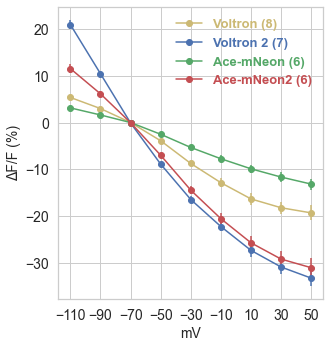

In [36]:
from matplotlib import font_manager

fig = plt.figure(figsize=[4.75,5])

sns.set(style='whitegrid')
x = np.linspace(-110,50,9)
sensors = ['V648','V260','G414','G840']
# sensors = ['G528','V754','V858']
ax= plt.subplot(111)

c_dict = {
    'V648':'y',
    'V260':'b',
    'G414':'g',
    'G840':'r',
    'V754':'y',
    'V858':'b',
    'G528':'g'
}

for sensor in sensors:
    print(sensor, df_construct_map.loc[sensor,'Construct_Ab'])
    df_sensor = df_p[df_p.Mutation==sensor]
    mean = np.mean(df_sensor['dFF_transient'].to_list(),axis=0)
    sem = np.std(df_sensor['dFF_transient'].to_list(),axis=0)/np.sqrt(len(df_sensor))
    
    trace_mean = np.mean(df_sensor['dFF_traces'].to_list(),axis=0)*100
    trace_sem = np.std(df_sensor['dFF_traces'].to_list(),axis=0)*100/np.sqrt(len(df_sensor))
    
    ax.errorbar(x, 100*np.flip(mean), yerr=100*np.flip(sem),fmt='o-', 
                        label=df_construct_map.loc[sensor,'Construct_Ab']+' (%d)' %len(df_sensor),
                color=c_dict[sensor])

ax.set_xlabel('mV',size=14)
ax.set_ylabel('\u0394F/F (%)',size=14)
plt.xticks(x)


# Legend:
font = font_manager.FontProperties(weight='bold',style='normal',size=13)
leg = ax.legend(frameon=False,prop=font) 
for item in leg.legendHandles: # remove line marker in legend
    item.set_visible(False)
for artist, text in zip(leg.legendHandles, leg.get_texts()): # set text the same color as line
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)

plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('/Volumes/genie/Presentations/Jihong/SfN materials/F-V_neg_series.pdf',format='pdf')
plt.show()

In [33]:
# from matplotlib import font_manager

# fig = plt.figure(figsize=[4.75,5]) # For F-V curve alone
# # fig = plt.figure(figsize=[7,5]) # For F-V curve and legend (legend cropped out in ppt)
# # fig = plt.figure(figsize=[2.5,2.5]) # For dFF traces at 30 mV

# sns.set(style='whitegrid')
# x = np.linspace(-110,50,9)
# sensors = df_p.Mutation.unique()
# # sensors = ['G414','G840','G525','G806','G877','G528','G243','V375','V260','V754','V648','V050','V858','V548']
# # sensors = ['G414','G840','G525','V648','V260','R222','R084','G528']
# # sensors = ['G840','V260']
# sensors = ['V648','V260','G414','G840']
# ax= plt.subplot(111)

# for sensor in sensors:
#     df_sensor = df_p[df_p.Mutation==sensor]
#     mean = np.mean(df_sensor['dFF_transient'].to_list(),axis=0)
#     sem = np.std(df_sensor['dFF_transient'].to_list(),axis=0)/np.sqrt(len(df_sensor))
    
#     trace_mean = np.mean(df_sensor['dFF_traces'].to_list(),axis=0)*100
#     trace_sem = np.std(df_sensor['dFF_traces'].to_list(),axis=0)*100/np.sqrt(len(df_sensor))

    
#     if mean[0]<0:
#         if 'G' in sensor:
#             idx = np.argmin(np.abs(np.flip(sorted(Mean_G_neg)) - mean[1]))

#             # For F-V curve
#             ax.errorbar(x, 100*np.flip(mean), yerr=100*np.flip(sem),fmt='o-', color='g',
#                         label=df_construct_map.loc[sensor,'Construct_Ab']+' (%d)' %len(df_sensor),
#                        alpha=np.linspace(0.6,1,len(Mean_G_neg))[idx])
            
# #             # For dFF trace at 30 mV
# #             x = np.arange(250,1750)/981.6
# #             x = x-x[0]
# #             ax.plot(x, trace_mean[1][250:1750], color='g',
# #                        alpha=np.linspace(0.4,1,len(Mean_G_neg))[idx])
# #             ax.fill_between(x,trace_mean[1][250:1750]+trace_sem[1][250:1750],
# #                             trace_mean[1][250:1750]-trace_sem[1][250:1750],color='g',
# #                             alpha=0.5*np.linspace(0.4,1,len(Mean_G_neg))[idx],
# #                            label=df_construct_map.loc[sensor,'Construct_Ab']+' (%d)' %len(df_sensor))

#         elif 'R' in sensor:
#             if sensor != 'R935': # R935 has mean[0]<0 but it was designed to be positive according to Jeremy
#                 idx = np.argmin(np.abs(np.flip(sorted(Mean_R_neg)) - mean[1]))

# #                 # For F-V curve
# #                 ax.errorbar(x, 100*np.flip(mean), yerr=100*np.flip(sem),fmt='o-', color='r',
# #                             label=df_construct_map.loc[sensor,'Construct_Ab']+' (%d)' %len(df_sensor),
# #                            alpha=np.linspace(0.4,1,len(Mean_R_neg))[idx])

#                 # For dFF trace at 30 mV
#                 x = np.arange(250,1750)/981.6
#                 x = x-x[0]
#                 ax.plot(x, trace_mean[1][250:1750], color='r',
#                            alpha=np.linspace(0.4,1,len(Mean_R_neg))[idx])
#                 ax.fill_between(x,trace_mean[1][250:1750]+trace_sem[1][250:1750],
#                                 trace_mean[1][250:1750]-trace_sem[1][250:1750],color='r',
#                                 alpha=0.6*np.linspace(0.4,1,len(Mean_R_neg))[idx],
#                                label=df_construct_map.loc[sensor,'Construct_Ab']+' (%d)' %len(df_sensor))
        
#         elif 'V' in sensor:
#             idx = np.argmin(np.abs(np.flip(sorted(Mean_V_neg)) - mean[1]))
            
#             # For F-V curve            
#             ax.errorbar(x, 100*np.flip(mean), yerr=100*np.flip(sem),fmt='o-', 
#                         label=df_construct_map.loc[sensor,'Construct_Ab']+' (%d)' %len(df_sensor),color='y',
#                        alpha=np.linspace(0.6,1,len(Mean_V_neg))[idx])

# #             # For dFF trace at 30 mV
# #             x = np.arange(250,1750)/981.6
# #             x = x-x[0]
# #             ax.plot(x, trace_mean[1][250:1750], color='y',
# #                        alpha=np.linspace(0.4,1,len(Mean_V_neg))[idx])
# #             ax.fill_between(x,trace_mean[1][250:1750]+trace_sem[1][250:1750],
# #                             trace_mean[1][250:1750]-trace_sem[1][250:1750],color='y',
# #                             alpha=0.5*np.linspace(0.4,1,len(Mean_V_neg))[idx])
# #             print(np.linspace(0.4,1,len(Mean_V_neg))[idx])


# # For F-V curve
# ax.set_xlabel('mV',size=14)
# ax.set_ylabel('\u0394F/F (%)',size=14)
# plt.xticks(x)


# # Legend:
# font = font_manager.FontProperties(weight='bold',style='normal',size=13)
# leg = ax.legend(frameon=False,prop=font) 
# for item in leg.legendHandles: # remove line marker in legend
#     item.set_visible(False)
# for artist, text in zip(leg.legendHandles, leg.get_texts()): # set text the same color as line
#     col = artist.get_color()
#     if isinstance(col, np.ndarray):
#         col = col[0]
#     text.set_color(col)


# # # For 30 mV dFF traces
# # ax.set_xlabel('S',size=13)
# # ax.set_ylabel('\u0394F/F (%)',size=14)
# # plt.xticks([0,0.5,1,1.5])
# # ax.set_xlim([1.2,1.3]) # for zoomed view
# # plt.xticks([1.2,1.25,1.3])


# plt.tick_params(labelsize=14)
# plt.tight_layout()
# savePath = '/Volumes/genie/Presentations/Jihong/GENIE data/220922/SfN & GENIE webpage/Ace_GEVIs/v2'
# if not os.path.exists(savePath):
#     os.mkdir(savePath)

# # plt.savefig('/Users/zhengj10/Desktop/patch_Voltron2_AcemNeon2.png')
# # plt.savefig(savePath+'/patch_N_sel_30mV.png',dpi=1200)
# # plt.savefig(savePath+'/patch_N_sel_F-V.png',dpi=1200)
# # plt.savefig(savePath+'/patch_N_sel_F-V_legend.png',dpi=1200)
# # plt.savefig('/Volumes/genie/Presentations/Jihong/SfN materials/F-V_neg_series.pdf',format='pdf')
# # plt.savefig(savePath+'/F-V_Neg_series.png',dpi=1200)
# # plt.savefig(savePath+'/dFF_trace_30mV_Neg_series.png',dpi=1200)
# # plt.savefig('/Volumes/genie/Jihong_GENIE_stuff/Meeting & presentation/SfN/2022/v2/dFF_trace_30mV_Neg_series.png',dpi=1200)
# # plt.savefig('/Volumes/genie/Jihong_GENIE_stuff/Meeting & presentation/SfN/2022/v2/F-V_Neg_series.png',dpi=1200)
# plt.show()

- Positive group

In [27]:
ax.get_xlim()

(1.2, 1.3)

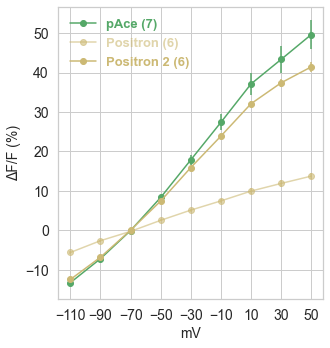

In [37]:
from matplotlib import font_manager

fig = plt.figure(figsize=[4.75,5])
# fig = plt.figure(figsize=[7,5])
# fig = plt.figure(figsize=[2.5,2.5])

sns.set(style='whitegrid')
x = np.linspace(-110,50,9)
# sensors = df_p.Mutation.unique()
# sensors = ['G414','G840','G525','G806','G877','G528','G243','V375','V260','V754','V648','V050','V858','V548']
# sensors = ['G528','V754','V858','R334']
sensors = ['G528','V754','V858']
ax= plt.subplot(111)

for sensor in sensors:
    df_sensor = df_p[df_p.Mutation==sensor]
    mean = np.mean(df_sensor['dFF_transient'].to_list(),axis=0)
    sem = np.std(df_sensor['dFF_transient'].to_list(),axis=0)/np.sqrt(len(df_sensor))
    
    trace_mean = np.mean(df_sensor['dFF_traces'].to_list(),axis=0)*100
    trace_sem = np.std(df_sensor['dFF_traces'].to_list(),axis=0)*100/np.sqrt(len(df_sensor))

    
    if mean[0]>0 or sensor == 'R935': # R935 has mean[0]<0 but it was designed to be positive according to Jeremy
        if 'G' in sensor:
            idx = np.argmin(np.abs(np.array(sorted(Mean_G_pos)) - mean[1]))

            # For F-V curve
            ax.errorbar(x, 100*np.flip(mean), yerr=100*np.flip(sem),fmt='o-', color='g',
                        label=df_construct_map.loc[sensor,'Construct_Ab']+' (%d)' %len(df_sensor),
                       alpha=np.linspace(0.4,1,len(Mean_G_pos))[idx])
            
#             # For dFF trace at 30 mV
#             x = np.arange(250,1750)/981.6
#             x = x-x[0]
#             ax.plot(x, trace_mean[1][250:1750], color='g',
#                        alpha=np.linspace(0.4,1,len(Mean_G_pos))[idx])
#             ax.fill_between(x,trace_mean[1][250:1750]+trace_sem[1][250:1750],
#                             trace_mean[1][250:1750]-trace_sem[1][250:1750],color='g',
#                             alpha=0.5*np.linspace(0.4,1,len(Mean_G_pos))[idx])

        elif 'R' in sensor:
        
            idx = np.argmin(np.abs(np.array(sorted(Mean_R_pos)) - mean[1]))

            # For F-V curve
            ax.errorbar(x, 100*np.flip(mean), yerr=100*np.flip(sem),fmt='o-', color='r',
                        label=df_construct_map.loc[sensor,'Construct_Ab']+' (%d)' %len(df_sensor),
                       alpha=np.linspace(0.6,1,len(Mean_R_pos))[idx])

#             # For dFF trace at 30 mV
#             x = np.arange(250,1750)/981.6
#             x = x-x[0]
#             ax.plot(x, trace_mean[1][250:1750], color='r',
#                        alpha=np.linspace(0.4,1,len(Mean_R_pos))[idx])
#             ax.fill_between(x,trace_mean[1][250:1750]+trace_sem[1][250:1750],
#                             trace_mean[1][250:1750]-trace_sem[1][250:1750],color='r',
#                             alpha=0.5*np.linspace(0.4,1,len(Mean_R_pos))[idx])
        
        elif 'V' in sensor:
            idx = np.argmin(np.abs(np.array(sorted(Mean_V_pos)) - mean[1]))
            
            # For F-V curve            
            ax.errorbar(x, 100*np.flip(mean), yerr=100*np.flip(sem),fmt='o-', 
                        label=df_construct_map.loc[sensor,'Construct_Ab']+' (%d)' %len(df_sensor),color='y',
                       alpha=np.linspace(0.6,1,len(Mean_V_pos))[idx])


#             # For dFF trace at 30 mV
#             x = np.arange(250,1750)/981.6
#             x = x-x[0]
#             ax.plot(x, trace_mean[1][250:1750], color='y',
#                        alpha=np.linspace(0.4,1,len(Mean_V_pos))[idx])
#             ax.fill_between(x,trace_mean[1][250:1750]+trace_sem[1][250:1750],
#                             trace_mean[1][250:1750]-trace_sem[1][250:1750],color='y',
#                             alpha=0.5*np.linspace(0.4,1,len(Mean_V_pos))[idx])
# #             print(np.linspace(0.4,1,len(Mean_V_pos))[idx])

            
# For F-V curve:
ax.set_xlabel('mV',size=14)
ax.set_ylabel('\u0394F/F (%)',size=14)
plt.xticks(x)


# Legend:
font = font_manager.FontProperties(weight='bold',style='normal',size=13)
leg = ax.legend(frameon=False,prop=font) 
for item in leg.legendHandles: # remove line marker in legend
    item.set_visible(False)
for artist, text in zip(leg.legendHandles, leg.get_texts()): # set text the same color as line
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)


# # For 30 mV dFF traces
# ax.set_xlabel('S',size=13)
# ax.set_ylabel('\u0394F/F (%)',size=14)
# plt.xticks([0,0.5,1,1.5])

plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('/Volumes/genie/Presentations/Jihong/SfN materials/F-V_pos_series.pdf',format='pdf')
# plt.savefig(savePath+'/patch_P_sel_30mV.png',dpi=1200)
# plt.savefig(savePath+'/patch_P_sel_F-V.png',dpi=1200)
# plt.savefig(savePath+'/patch_P_sel_F-V_legend.png',dpi=1200)

# plt.savefig(savePath+'/F-V_Pos_series_leg.png',dpi=1200)
# plt.savefig(savePath+'/dFF_trace_30mV_Pos_series.png',dpi=1200)
# plt.savefig('/Volumes/genie/Jihong_GENIE_stuff/Meeting & presentation/SfN/2022/dFF_trace_30mV_pos_series.png',dpi=1200)
# plt.savefig('/Volumes/genie/Jihong_GENIE_stuff/Meeting & presentation/SfN/2022/v2/F-V_Pos_series_leg.png',dpi=1200)
plt.show()

- dFF traces at 30 mV - all sensors

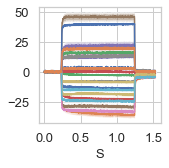

In [16]:
plt.figure(figsize=[2.5,2.5])
ax = plt.subplot(111)
for sensor in sensors:
    df_sensor = df_p[df_p.Mutation==sensor]

    mean = np.mean(df_sensor['dFF_traces'].to_list(),axis=0)*100
    sem = np.std(df_sensor['dFF_traces'].to_list(),axis=0)*100/np.sqrt(len(df_sensor))

    x = np.arange(250,1750)/981.6
    x = x-x[0]
    ax.plot(x, mean[1][250:1750])
    ax.fill_between(x,mean[1][250:1750]+sem[1][250:1750],mean[1][250:1750]-sem[1][250:1750],alpha=0.5)
ax.set_xlabel('S',size=13)
# ax.set_ylabel('\u0394F/F (%)')
# ax.set_title('Response to 30 mV',size=14)
plt.tick_params(labelsize=13)
plt.xticks([0,0.5,1,1.5])
plt.tight_layout()
# plt.savefig('/Volumes/genie/Presentations/Jihong/GENIE production/220426/dFF_traces_30mV_G_series.png',dpi=1200)
plt.show()

#### Kinetics

- Jihong code for double exponential fit

In [ ]:
# from scipy.optimize import curve_fit
# def func(x, a, b, c, d, e):
#     y = -a * np.exp(-b * x) + -c * np.exp(-d * x) + e
#     return y

In [ ]:
# df_sel = df_p[df_p['Mutation']=='G806']

In [ ]:
# first_on_frame = 481
# first_off_frame = 1468
# x_on = peaks[first_on_frame:first_on_frame+100]/40.0
# x_on = x_on - x_on[0]
# x_on

In [ ]:
# i=1
# plt.figure(figsize=[14,148])

# stride = 50

# first_on_frame = 481
# first_off_frame = 1468

# x_on = x_on = peaks[first_on_frame:first_on_frame+stride]/40.0
# x_on = x_on - x_on[0]

# x_off = peaks[first_off_frame:first_off_frame+stride]/40.0
# x_off = x_off - x_off[0]

# Mutation = []

# Tau_on_f = []
# Tau_on_s = []
# Percent_on = []

# Tau_off_f = []
# Tau_off_s = []
# Percent_off = []

# for idx,r in df_p.iterrows():
#     Mutation.append(r['Mutation'])
    
#     trace_on_to_fit = r['dFF_traces'][1][first_on_frame:first_on_frame+stride]
#     trace_on_to_fit = trace_on_to_fit-trace_on_to_fit[-1]+0.02
    
#     trace_off_to_fit = r['dFF_traces'][1][first_off_frame:first_off_frame+stride]
#     trace_off_to_fit = trace_off_to_fit-trace_off_to_fit[-1]+0.02

#     try:
#         popt, pcov = curve_fit(func, x_on, trace_on_to_fit, maxfev=5000)
#         if 1/popt[1]<1/popt[3]:
#             tau_on_f = 1/popt[1]
#             tau_on_s = 1/popt[3]
#             percent_on = 100*tuple(popt)[0]/(tuple(popt)[0]+tuple(popt)[2])
#         else:
#             tau_on_f = 1/popt[3]
#             tau_on_s = 1/popt[1]
#             percent_on = 100*(1-tuple(popt)[0]/(tuple(popt)[0]+tuple(popt)[2]))
            
#         Tau_on_f.append(tau_on_f)
#         Tau_on_s.append(tau_on_s)
#         Percent_on.append(percent_on)
        
#     except:
#         Tau_on_f.append(np.nan)
#         Tau_on_s.append(np.nan)
#         Percent_on.append(np.nan)
        
#     ax = plt.subplot(37,4,i)
#     ax.plot(trace_on_to_fit)
#     ax.plot(x_on ,func(x_on, *popt), 'r-')
#     i+=1

#     try:
            
#         popt, pcov = curve_fit(func, x_off, trace_off_to_fit, maxfev=5000)
#         if 1/popt[1]<1/popt[3]:
#             tau_off_f = 1/popt[1]
#             tau_off_s = 1/popt[3]
#             percent_off = 100*tuple(popt)[0]/(tuple(popt)[0]+tuple(popt)[2])
#         else:
#             tau_off_f = 1/popt[3]
#             tau_off_s = 1/popt[1]
#             percent_off = 100*(1-tuple(popt)[0]/(tuple(popt)[0]+tuple(popt)[2]))
        
#         Tau_off_f.append(tau_off_f)
#         Tau_off_s.append(tau_off_s)
#         Percent_off.append(percent_off)

#     except:

        
#         Tau_off_f.append(np.nan)
#         Tau_off_s.append(np.nan)
#         Percent_off.append(np.nan)
        
# #     print(sensor)
# #     print(tau_f)
# #     print(tau_s)
    

# #     ax = plt.subplot(37,4,i)
# #     ax.plot(trace_off_to_fit)
# #     ax.plot(x_off ,func(x_off, *popt), 'r-')
# #     ax.set_title(r['Mutation'])
# #     i+=1
    

In [ ]:
# df_k = pd.DataFrame()

In [ ]:
# df_k['Mutation'] = Mutation
# df_k['Tau_on_fast (ms)'] = Tau_on_f
# df_k['Tau_on_slow (ms)'] = Tau_on_s
# df_k['Tau_on_fast_percent (%)'] = Percent_on

# df_k['Tau_off_fast (ms)'] = Tau_off_f
# df_k['Tau_off_slow (ms)'] = Tau_off_s
# df_k['Tau_off_fast_percent (%)'] = Percent_off

In [ ]:
# df_k

In [ ]:
# fig = plt.figure(figsize=[36,8])
# ax = plt.subplot(111)
# sns.boxplot(x='Mutation',y='Tau_on_fast (ms)',data=df_k,ax=ax,boxprops=dict(alpha=0.3))
# sns.swarmplot(x='Mutation',y='Tau_on_fast (ms)',data=df_k,ax=ax,size=8)
# # ax.set_ylim([0,100])
# ax.set_xlabel('')
# ax.set_ylabel('Tau off fast percent (%)',size=14)
# plt.tick_params(labelsize=13)
# plt.xticks(rotation=45,ha='right')
# plt.ylim([0,10])
# fig.set_size_inches(12,3)
# plt.tight_layout()
# # plt.savefig('/Volumes/genie/Presentations/Jihong/GENIE production/220426/tau_off_f_percent.png',dpi=1200)
# plt.show()

- Creat table for kinetics data above

In [ ]:
# # df_p_k = df.dropna()
# # df.Date.unique()

# T_on_f = []
# T_on_s = []
# T_on_f_percent = []

# T_off_f = []
# T_off_s = []
# T_off_f_percent = []

# Construct = []
# N = []
# for sensor in df_p_k.Mutation.unique():
#     df_temp = df_p_k[df_p_k['Mutation']==sensor]
#     t_on_f_mean = df_temp['Tau_on_fast (ms)'].mean()
#     t_on_f_sem = df_temp['Tau_on_fast (ms)'].sem()
#     t_on_s_mean = df_temp['Tau_on_slow (ms)'].mean()
#     t_on_s_sem = df_temp['Tau_on_slow (ms)'].sem()
    
#     t_off_f_mean = df_temp['Tau_off_fast (ms)'].mean()
#     t_off_f_sem = df_temp['Tau_off_fast (ms)'].sem()
#     t_off_s_mean = df_temp['Tau_off_slow (ms)'].mean()
#     t_off_s_sem = df_temp['Tau_off_slow (ms)'].sem()

#     t_on_f_percent_mean = df_temp['Tau_on_fast_percent (%)'].mean()
#     t_on_f_percent_sem = df_temp['Tau_on_fast_percent (%)'].sem()
    
#     t_off_f_percent_mean = df_temp['Tau_off_fast_percent (%)'].mean()
#     t_off_f_percent_sem = df_temp['Tau_off_fast_percent (%)'].sem()

    
#     Construct.append(sensor)
#     T_on_f.append('%s+/-%s' %(round(t_on_f_mean,2),round(t_on_f_sem,2)))
#     T_on_s.append('%s+/-%s' %(round(t_on_s_mean,2),round(t_on_s_sem,2)))
#     T_off_f.append('%s+/-%s' %(round(t_off_f_mean,2),round(t_off_f_sem,2)))
#     T_off_s.append('%s+/-%s' %(round(t_off_s_mean,2),round(t_off_s_sem,2)))    
    
#     T_on_f_percent.append('%s+/-%s' %(round(t_on_f_percent_mean,2),round(t_on_f_percent_sem,2)))
#     T_off_f_percent.append('%s+/-%s' %(round(t_off_f_percent_mean,2),round(t_off_f_percent_sem,2)))
    
#     n = len(df_temp)
#     N.append(n)

In [ ]:
# df_kinetics = pd.DataFrame()

In [ ]:
# df_kinetics['Construct'] = Construct
# df_kinetics['Tau on fast (ms)'] = T_on_f
# df_kinetics['Tau on slow (ms)'] = T_on_s
# df_kinetics['% fast (on)'] = T_on_f_percent
# df_kinetics['Tau off fast (ms)'] = T_off_f
# df_kinetics['Tau off slow (ms)'] = T_off_s
# df_kinetics['% fast (off)'] = T_off_f_percent
# df_kinetics['N'] = N

In [ ]:
# df_p_k = df[(df['Tau_on_fast_percent (%)']<100)&(df['Tau_off_fast_percent (%)']<100)&
#             (df['Tau_on_fast_percent (%)']>0)&(df['Tau_off_fast_percent (%)']>0)&(df['Mutation']!='G525')&
#             (df['Mutation']!='R145')&(df['Mutation']!='R935')&(df['Mutation']!='R850')]
# df_p_k.shape

In [ ]:
# df_kinetics.to_excel('/Volumes/genie/Presentations/Jihong/GENIE production/220426/Kinetics.xlsx')
# df_kinetics

In [ ]:
# tuple(popt)[2]

In [ ]:
# plt.figure(figsize=[4,4])
# ax = plt.subplot(111)
# for sensor in sensors:
#     df_sensor = df_p[df_p.Mutation==sensor]
#     for i,r in df_sensor.iterrows():
#         x = np.arange(100)
#         trace_to_fit = r['dFF_traces'][1][481:581]
#         popt, pcov = curve_fit(func, x, trace_to_fit,maxfev=5000)
#         tau_f = np.min([1/popt[1],1/popt[3]])
#         tau_s = np.max([1/popt[1],1/popt[3]])
#         print(sensor)
#         print(tau_f)
#         print(tau_s)

In [ ]:
# plt.plot(x,*popt)

- 10-90% time from double fit by Ben

In [20]:
Patch_ID = []
Construct_ID = []
Construct = []
On_time = []
Off_time = []
for i,r in df.iterrows():
    
    matFile = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'001.mat')
    if not os.path.exists(matFile):
        print(str(i).zfill(3)+'.mat not existing')
        continue
    Patch_ID.append(r['Mutation'])
    Construct_ID.append(df_construct_map.loc[r['Mutation'],'ID'])
    Construct.append(df_construct_map.loc[r['Mutation'],'Construct'])
    matData = h5py.File(matFile,'r')
    d = matData['params']['fit_double'] # double fit has much less nan value
    st = d[0]
    obj = matData[st]
    on_time = obj['bkg_norm_ave_ontime'][0]
    off_time = obj['bkg_norm_ave_offtime'][0]
    On_time.append(on_time)
    Off_time.append(off_time)
    print(off_time)
print('Done!')

16.465064005338263
58.544936107364265
14.324482230227659
10.692604502914037
9.729611797482448
nan
49.63826853250794
9.669658771069635
11.405436176096828
15.344034530849285
24.988506661038173
16.395325206669895
17.918266476691997
17.284980267105084
19.305084139946757
nan
82.23263142907945
226.0484754604488
nan
104.48694929700059
25.002288972680844
175.95909475765143
366.515212424272
166.2267072287416
285.68854175441743
159.82392010111403
140.64722076783096
5.609876611556729
3.892836455304405
4.715728749066784
13.400608794539721
4.679180637331228
6.212208406635227
6.017793081341324
4.998250840217906
3.730391922471881
2.5862824253788403
3.4757043475221963
3.329014061050202
3.742524053468742
5.883734912474665
3.376819326237637
4.348490308942701
3.742996228335869
4.605611260754131
0.5106100932453046
3.8183170619404336
3.9396736479109222
6.397469312813882
4.1007753171029435
nan
6.072421996845833
6.600731514270137
7.1359331951987315
7.065560656730895
8.472804918606471
7.476785199668484
8.6066

In [21]:
df['On_time'] = On_time
df['Off_time'] = Off_time

In [22]:
Patch_ID = []
Construct_ID = []
Construct = []
On_time = []
Off_time = []
for i,r in df_p.iterrows():
    
    matFile = os.path.join(imgPath,r['Date'],r['Plate'],r['Cell'],'001.mat')
    if not os.path.exists(matFile):
        print(str(i).zfill(3)+'.mat not existing')
        continue
    Patch_ID.append(r['Mutation'])
    Construct_ID.append(df_construct_map.loc[r['Mutation'],'ID'])
    Construct.append(df_construct_map.loc[r['Mutation'],'Construct'])
    matData = h5py.File(matFile,'r')
    d = matData['params']['fit_double'] # double fit has much less nan value
    st = d[0]
    obj = matData[st]
    on_time = obj['bkg_norm_ave_ontime'][0]
    off_time = obj['bkg_norm_ave_offtime'][0]
    On_time.append(on_time)
    Off_time.append(off_time)
#     print(off_time)
print('Done!')

Done!


In [23]:
df_k_time = pd.DataFrame({'Patch_ID':Patch_ID,'Construct_ID':Construct_ID,'Construct':Construct,'On_time':On_time,
                         'Off_time':Off_time})

In [24]:
# df_p.columns
# df_construct_map.ID.unique()
# df_p.Mutation.unique()
# df_construct_map.index
# df_construct_map.columns

In [25]:
colors = []
for i in df_k_time.Patch_ID.unique():
    if "G" in i:
        colors.append('g')
    elif "R" in i:
        colors.append('r')
    elif "V" in i:
        colors.append('y')
palette = sns.set_palette(colors)

In [26]:
# palette
# colors
# df_k_time.Patch_ID.unique()
# df_k_time.columns

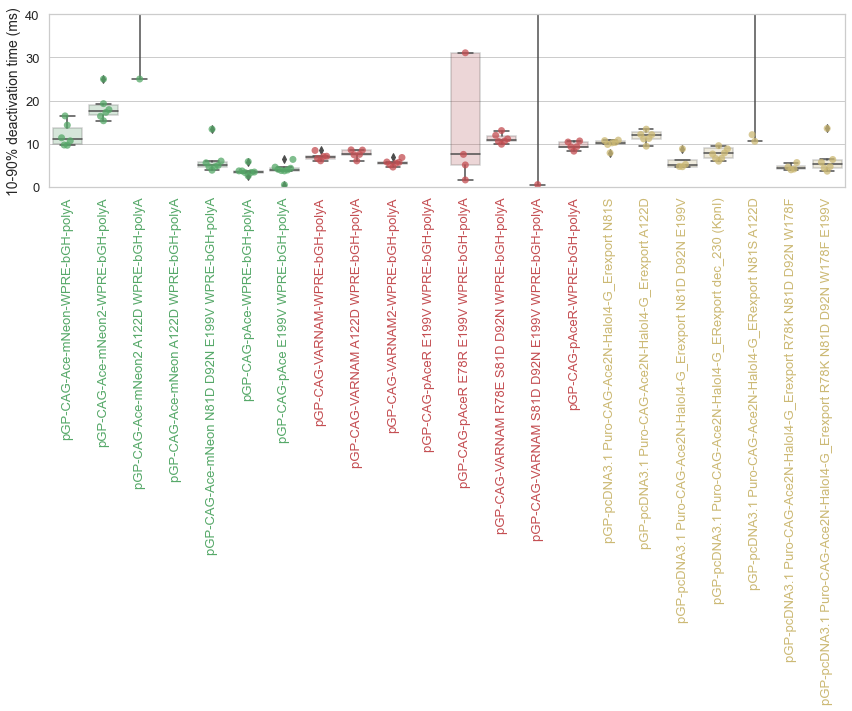

In [27]:
fig = plt.figure(figsize=[33.6,28])
ax1 = plt.subplot(111)
sns.swarmplot(x='Construct',y='Off_time',data=df_k_time,ax=ax1,size=7,alpha=0.75,palette=palette)
sns.boxplot(x='Construct',y='Off_time',data=df_k_time,ax=ax1,boxprops=dict(alpha=0.25))
ax1.set_xlabel('')
ax1.set_ylabel('10-90% deactivation time (ms)',size=14)
plt.tick_params(labelsize=13)
plt.xticks(rotation=90,ha='center')

c = 0
for item in ax1.get_xticklabels():
    item.set_color(colors[c])
    c+=1
    
ax1.set_ylim([0,40])
fig.set_size_inches(12,10)
plt.tight_layout()
savePath = '/Volumes/genie/Jihong_GENIE_stuff/Ace based sensors/Presentation/revised'
if not os.path.exists(savePath):
    os.mkdir(savePath)
# plt.savefig(savePath+'/kinetics_off.png',dpi=1200)
plt.show()

- Creat a table for data above

In [28]:
df_k_time.columns

Index(['Patch_ID', 'Construct_ID', 'Construct', 'On_time', 'Off_time'], dtype='object')

In [87]:
df_k_time = df_k_time.dropna()


T_on = []
T_off = []

Construct = []
N = []

T_on_mean = []
T_off_mean = []

for sensor in df_k_time.Construct.unique():
    df_temp = df_k_time[df_k_time['Construct']==sensor]
    
    t_on_mean = df_temp['On_time'].mean()
    t_off_mean = df_temp['Off_time'].mean()
    
    t_on_sem = df_temp['On_time'].sem()
    t_off_sem = df_temp['Off_time'].sem()

    Construct.append(sensor.replace('dot','.'))
    
    T_on.append('%s+/-%s' %(round(t_on_mean,2),round(t_on_sem,2)))
    T_off.append('%s+/-%s' %(round(t_off_mean,2),round(t_off_sem,2)))

    
    n = len(df_temp)
    
    N.append(n)
    T_on_mean.append(t_on_mean)
    T_off_mean.append(t_off_mean)

In [88]:
df_kinetics = pd.DataFrame()
df_color_values = pd.DataFrame()


df_kinetics['Construct'] = Construct
df_kinetics['Activation time (ms)'] = T_on
df_kinetics['Deactivation time (ms)'] = T_off
df_kinetics['N'] = N

df_color_values['T_on_mean'] = T_on_mean
df_color_values['T_off_mean'] = T_off_mean

In [98]:
df_kinetics.style.set_properties(subset=['Construct'],**{'width':'490px'})

# def make_pretty(styler):
#     styler.set_caption("Weather Conditions")
# #     styler.format(rain_condition)
#     styler.format_index(lambda v: v.strftime("%A"))
#     styler.background_gradient(axis=None, vmin=1, vmax=5, cmap="jet")
#     return styler

# weather_df
# df_kinetics.style.pipe(make_pretty)


# def highlight(x):
#     c = f"background-color:red" 
#     #condition
# #     m = x["T_on_mean"]
#     m = x["N"]
#     # DataFrame of styles
#     df1 = pd.DataFrame('', index=x.index, columns=x.columns)
#     # set columns by condition
#     df1.loc[m, 'Activation time (ms)'] = c
#     return df1
# df_kinetics.style.apply(highlight, axis=None)



# df_kinetics.style.background_gradient(cmap="cool", subset=['T_on_mean'])


from matplotlib import colors

def b_g(s, cmap='PuBu', low=0, high=0):
    # Pass the columns from Dataframe A
    s = 'T_on_mean'
    a = df_color_values.loc[:,s].copy()
#     rng = a.max() - a.min()
    rng = 50
#     norm = colors.Normalize(a.min() - (rng * low),
#                         a.max() + (rng * high))
    norm = colors.Normalize(0,rng)
    normed = norm(a.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]


# def highlight_cols(x,s, cmap='PuBu', low=0, high=0):
#     #copy df to new - original data are not changed
#     df = x.copy()
#     #select all values to default value - red color
#     df.loc[:,:] = b_g(s, cmap='PuBu', low=0, high=0)
#     #overwrite values grey color
#     #return color df
#     return df    

# df_kinetics.style.set_properties(**{'text-align': 'left'})
# display(df_kinetics)

# df_kinetics[['Activation time (ms)']].style.set_properties(**{'text-align': 'left'})
df_kinetics[['Activation time (ms)']].style.apply(b_g,cmap='cool')
# df_kinetics[['Deactivation time (ms)']].style.apply(b_g,cmap='cool')
# df_kinetics


,Activation time (ms)
0,51.43+/-22.3
1,30.6+/-6.05
2,110.09+/-30.39
3,28.39+/-3.88
4,49.24+/-27.58
5,12.64+/-3.56
6,13.28+/-2.76
7,8.91+/-1.67
8,6.8+/-0.79
9,3.75+/-0.76


In [92]:
df_kinetics['Activation time (ms)']

0       51.43+/-22.3
1        30.6+/-6.05
2     110.09+/-30.39
3       28.39+/-3.88
4      49.24+/-27.58
5       12.64+/-3.56
6       13.28+/-2.76
7        8.91+/-1.67
8         6.8+/-0.79
9        3.75+/-0.76
10      214.35+/-nan
11     148.12+/-61.2
12       22.0+/-3.06
13    113.43+/-78.03
14      28.97+/-5.18
15       5.54+/-0.21
16       6.71+/-1.64
17      36.33+/-7.24
18       9.69+/-1.92
19       5.09+/-0.79
20       10.62+/-2.2
21      16.31+/-2.24
Name: Activation time (ms), dtype: object

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt  
from matplotlib import colors

def b_g(s, cmap='PuBu', low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    rng = a.max() - a.min()
    norm = colors.Normalize(a.min() - (rng * low),
                        a.max() + (rng * high))
    normed = norm(a.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

B.style.apply(b_g,cmap='PuBu')

In [40]:
sumPath

'/Volumes/genie/Jihong_GENIE_stuff/Ace based sensors'

In [ ]:
df_kinetics.to_excel(sumPath+'/Kinetics_by_10-90_time.xlsx')

In [10]:
df_FS_screen

,Date,Plate,Well,Construct,Trial,dFF,Tau_on,Tau_off,Time_on,Time_off
0,20220502_GEVIs,P01a-20220418_Ace-mNeon,A03,487.7,a,-0.071502,64.800337,84.204628,30.448498,106.044753
1,20220502_GEVIs,P01a-20220418_Ace-mNeon,A04,487.8,a,-0.169017,20.836097,5.824904,2.925749,17.485545
2,20220502_GEVIs,P01a-20220418_Ace-mNeon,A04,487.8,b,-0.176495,13.600895,5.349346,2.567736,15.527898
3,20220502_GEVIs,P01a-20220418_Ace-mNeon,A04,487.8,c,-0.164250,14.774699,5.484448,2.655268,16.017525
4,20220502_GEVIs,P01a-20220418_Ace-mNeon,A04,487.8,d,-0.193406,16.626111,5.594954,2.746097,16.504021
...,...,...,...,...,...,...,...,...,...,...
606,20220502_GEVIs,P03a-20220418_VARNAM,H10,639.3,b,0.009836,13.027491,29.669802,8.634384,70.092199
607,20220502_GEVIs,P03a-20220418_VARNAM,H10,639.3,c,0.014290,6.305764,211.048618,10.548903,165.295558
608,20220502_GEVIs,P03a-20220418_VARNAM,H10,639.3,d,0.014461,73.306564,88.874806,32.879073,99.350627
609,20220502_GEVIs,P03a-20220418_VARNAM,H10,639.3,e,0.023462,2.152826,146.239081,3.986895,182.342574


#### Mask

In [ ]:
plt.figure(figsize=[12,45])
i = 1
for idx,r in df_p.iterrows():
    maskPath = os.path.join(sumPath,r['Date'],r['Plate'],r['Cell'])
    mask = np.load(maskPath+'/mask.npy')
    ax = plt.subplot(7,20,i)
    ax.imshow(mask,cmap='gray')
    ax.text(15,50,r['Mutation'],color='y',size=15,weight='bold',ha='center',rotation=-90)
    ax.axis('off')
    i+=1
plt.tight_layout(pad=0.3)
# plt.savefig(savePath+'/Mask_R_series.png',dpi=1200)
plt.show()

In [3]:
# print(pd.__version__)

1.4.2


In [70]:
dFF_patch = []
dFF_screen = []
C = []
C_label = []
for c in df_p.Mutation.unique():
    C.append(c)
#     print(c)
#     print(df_construct_map.loc[c,'ID'])
    
    df_patch = df_p[df_p.Mutation==c]
    dff_patch = np.median(df_patch.dFF_transient.to_list(),axis=0)[1]
    dFF_patch.append(dff_patch)
    
    df_screen = df_FS_screen[df_FS_screen['Construct']==df_construct_map.loc[c,'ID']]
    df_screen = df_screen.dropna()
    dff_screen = np.median(df_screen.dFF.to_list())
    dFF_screen.append(dff_screen)
    C_label.append(c+ ' (n=%s)' %len(df_screen))
    


In [50]:
dFF_screen

[-0.01709458566074999,
 -0.08683548596306993,
 -0.05037137965907017,
 -0.08159710608431062,
 0.0020948425767089544,
 0.08529046673949638,
 0.05769048393058696,
 -0.03769573115893391,
 -0.05026089889820827,
 -0.06077902864683489,
 0.0304540235146767,
 0.017594731541412507,
 0.033535821370158515,
 0.026069675564332418,
 0.05348536706867525,
 -0.085171579219782,
 -0.0984475124088776,
 0.05916940408620681,
 -0.06648440700629302,
 -0.03200816742860093,
 0.1012115381130769,
 0.26344378751103775]

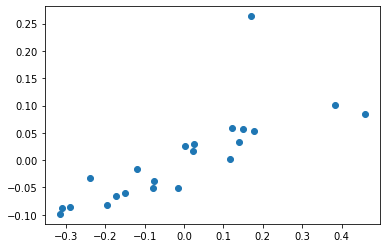

In [51]:
plt.scatter(dFF_patch,dFF_screen)
# plt.xticks(C)

In [33]:
df_corr = pd.DataFrame({'Construct':C,'dFF_patch':dFF_patch,'dFF_screen':dFF_screen})

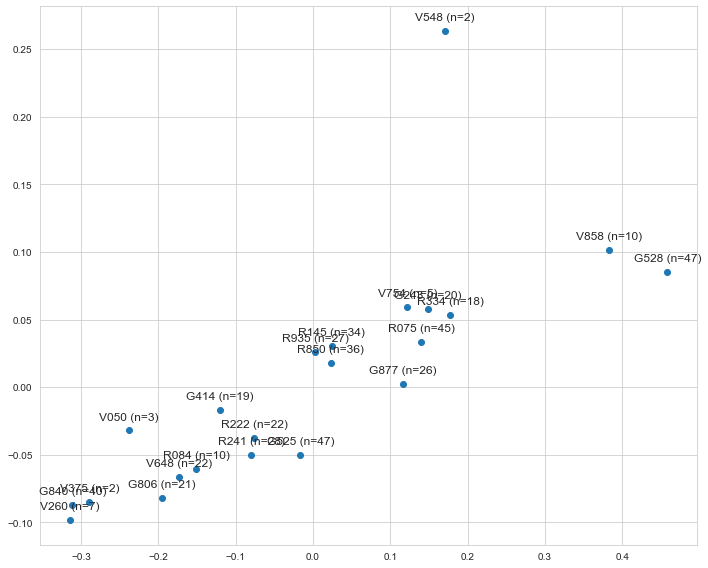

In [79]:
plt.figure(figsize=[7.5,6])
sns.set_style('whitegrid')
# # palette = sns.color_palette("bright", len(df_corr))
# sns.scatterplot(x='dFF_patch',y='dFF_screen',data=df_corr,hue='Construct',s=100)

ax = plt.subplot(111)
# ax.text(dFF_l[i],no_pixels_l[i]+text_height, "%s" %construct.split(';')[0][-8:], ha="center",size=12)
ax.scatter(dFF_patch,dFF_screen)
text_height = (ax.get_ylim()[1]-ax.get_ylim()[0])*0.02
for i,construct in enumerate(Construct):
    ax.text(dFF_patch[i],dFF_screen[i]+text_height, C_label[i],ha="center",size=12)
ax.set_xlabel()
plt.tight_layout()
plt.show()

In [36]:
df_corr[df_corr['dFF_screen']>0.2]

,Construct,dFF_patch,dFF_screen
21,V548,0.170329,0.263444


In [46]:
df_temp_x = df_FS_screen[df_FS_screen['Construct']=='487.7']
len(df_temp_x.dropna())

19

In [47]:
df_temp_x.dropna()

,Date,Plate,Well,Construct,Trial,dFF,Tau_on,Tau_off,Time_on,Time_off
0,20220502_GEVIs,P01a-20220418_Ace-mNeon,A03,487.7,a,-0.071502,64.800337,84.204628,30.448498,106.044753
37,20220502_GEVIs,P01a-20220418_Ace-mNeon,B03,487.7,a,-0.070063,1.879802,115.456997,3.439397,158.200904
79,20220502_GEVIs,P01a-20220418_Ace-mNeon,C03,487.7,a,-0.057221,37.109194,117.092135,29.240298,113.100041
80,20220502_GEVIs,P01a-20220418_Ace-mNeon,C03,487.7,b,-0.036831,75.881254,65.160299,26.665476,114.324910
81,20220502_GEVIs,P01a-20220418_Ace-mNeon,C03,487.7,c,0.036253,35.467706,22.540574,9.912475,61.857229
118,20220502_GEVIs,P01a-20220418_Ace-mNeon,D03,487.7,a,0.094800,0.000004,177.182957,0.000007,161.333325
119,20220502_GEVIs,P01a-20220418_Ace-mNeon,D03,487.7,b,-1.085047,14.121945,25.222701,8.122289,60.992996
121,20220502_GEVIs,P01a-20220418_Ace-mNeon,D03,487.7,d,-0.132672,4.192629,3.113645,1.321560,8.377534
122,20220502_GEVIs,P01a-20220418_Ace-mNeon,D03,487.7,e,-0.186515,3.627326,8.678432,2.470927,20.415199
123,20220502_GEVIs,P01a-20220418_Ace-mNeon,D03,487.7,f,0.025317,206.406453,99.569810,46.218854,103.104303
